# DSAI Mini-project 
# HDB Resale Price Analysis 

This study aims to develop a regression model to accurately predict HDB resale prices in Singapore by analyzing key factors such as flat type, size, location, and market trends. Beyond price prediction, we will conduct a market analysis to identify shifts in correlations, emerging pricing trends, and external factors influencing the resale market. Our goal is to provide homeowners, buyers, and policymakers with a data-driven tool for better decision-making in the housing market

This file contains the EDA, Data visualisations and ML tasks for our project. For more on the data collection please refer to the dataprep.ipynb file



In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os 

import folium
from folium import Choropleth
import json
from shapely.geometry import shape
from tqdm import tqdm
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import  MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


sns.set_style('darkgrid')

In total, there are 7 datasets that are relevant to our study. 

4 of which are the datasets that we have found online from data.gov regarding the resale price of HDBs. 

3 of which are the datasets we have self collected via webscraping and api calling, which are on hdb, mall and mrt locational data

In [3]:
dfs = [] 
for file in os.listdir('./datasets'):
    if file.endswith('.csv') and 'location' not in file and file != 'merged_df.csv':  # Check if the file is a CSV
        dfs.append(pd.read_csv(f"./datasets/{file}"))

df = pd.concat(dfs, ignore_index=True)  # Ignore index to avoid duplication in the concatenated dataframe
df.head(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,2000-01,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0,NaN
1,2000-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,144000.0,NaN


In [4]:
hdb_loc_df = pd.read_csv('./datasets/hdb_location.csv')
mall_loc_df = pd.read_csv('./datasets/mall_location.csv')
mrt_loc_df = pd.read_csv('./datasets/mrt_location.csv')

## Exploratory Data Analysis 
First we will conduct EDA on our hdb resale dataset try to understand what we are working with, as well as see how to clean up our dataset

###  Understanding our data

Here are some summary details and statistics of our dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660656 entries, 0 to 660655
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                660656 non-null  object 
 1   town                 660656 non-null  object 
 2   flat_type            660656 non-null  object 
 3   block                660656 non-null  object 
 4   street_name          660656 non-null  object 
 5   storey_range         660656 non-null  object 
 6   floor_area_sqm       660656 non-null  float64
 7   flat_model           660656 non-null  object 
 8   lease_commence_date  660656 non-null  int64  
 9   resale_price         660656 non-null  float64
 10  remaining_lease      238802 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 55.4+ MB


We see that our dataset consists of a total of 11 columns, and based on research online these are what each of the columns represent


| Feature | Description |
|---------|------------|
| **month** (object) | The month in which the resale transaction took place, formatted as "YYYY-MM". |
| **town** (object) | The town or estate in Singapore where the HDB flat is located (e.g., Ang Mo Kio, Bedok, Jurong West). |
| **flat_type** (object) | The type of HDB flat based on the number of rooms, such as "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE", etc. |
| **block** (object) | The block number of the HDB flat. |
| **street_name** (object) | The name of the street where the block is located. |
| **storey_range** (object) | The range of floors where the unit is located, typically in ranges like "01 TO 03", "04 TO 06", etc. |
| **floor_area_sqm** (float64) | The size of the flat in square meters (sqm). |
| **flat_model** (object) | The specific model of the flat (e.g., "Improved", "New Generation", "Model A", "Maisonette"), indicating the design and layout. |
| **lease_commence_date** (int64) | The year when the lease for the flat started. |
| **resale_price** (float64) | The transaction price of the flat in Singapore dollars (SGD). |
| **remaining_lease** (object) | The remaining lease period of the flat at the time of the transaction (e.g., "85 years 2 months"). This column has many missing values, possibly due to it not being recorded for older transactions. |

### Dataframe Size

In [6]:
df.shape

(660656, 11)

Overall there are up to 660,656 entries in our dataset with 11 columns. 

### Numerical Features

In [7]:
# Disable scientific notation 
pd.set_option('display.float_format', '{:,.7f}'.format)  # This will show up to 10 decimal places7
df.describe()

,floor_area_sqm,lease_commence_date,resale_price
count,"660,656.0000000","660,656.0000000","660,656.0000000"
mean,96.6914270,"1,990.7894986","374,420.5161277"
std,25.0038018,11.6739151,"174,498.6215847"
min,28.0000000,"1,966.0000000","28,000.0000000"
25%,74.0000000,"1,983.0000000","245,000.0000000"
50%,95.0000000,"1,988.0000000","348,000.0000000"
75%,113.0000000,"1,999.0000000","465,000.0000000"
max,366.7000000,"2,021.0000000","1,600,000.0000000"


Here we see that:
- Floor area ranges from 28 sqm to 366 sqm, with a mean of 96 sqm. The maximum value is significantly higher than the third quartile (113 sqm), indicating potential outliers. Since larger spaces typically lead to higher prices, this feature will likely be a strong predictor.

- Lease commence date spans from 1966 to 2021, with no apparent outliers, making it a stable quantitative feature.

- Resale price ranges from 28,000 to 1,600,000, with a mean of 374,420. The third quartile is only 465,000, suggesting high-value outliers that could skew the analysis. Careful metric selection is necessary.

### Categorical variables

In [8]:
df.describe(include='object')

,month,town,flat_type,block,street_name,storey_range,flat_model,remaining_lease
count,660656,660656,660656,660656,660656,660656,660656,238802
unique,303,26,7,2734,578,25,21,735
top,2010-07,WOODLANDS,4 ROOM,2,YISHUN RING RD,04 TO 06,Model A,68
freq,3679,57365,262762,2726,10767,161899,202889,2328


In [9]:
df['storey_range']

0         07 TO 09
1         04 TO 06
2         07 TO 09
3         07 TO 09
4         07 TO 09
            ...   
660651    01 TO 03
660652    10 TO 12
660653    10 TO 12
660654    04 TO 06
660655    07 TO 09
Name: storey_range, Length: 660656, dtype: object

In [10]:
print(f"""
Flat types: {', '.join(df['flat_type'].unique())}'

Flat Storey Range: {', '.join(df['storey_range'].unique())}

Flat Model: {', '.join(df['flat_model'].unique())}

""")


Flat types: 3 ROOM, 4 ROOM, 5 ROOM, EXECUTIVE, 2 ROOM, MULTI-GENERATION, 1 ROOM'

Flat Storey Range: 07 TO 09, 04 TO 06, 01 TO 03, 10 TO 12, 13 TO 15, 16 TO 18, 19 TO 21, 22 TO 24, 25 TO 27, 28 TO 30, 31 TO 33, 40 TO 42, 37 TO 39, 34 TO 36, 46 TO 48, 43 TO 45, 49 TO 51, 06 TO 10, 01 TO 05, 11 TO 15, 16 TO 20, 21 TO 25, 26 TO 30, 36 TO 40, 31 TO 35

Flat Model: Improved, New Generation, Model A, Standard, Apartment, Simplified, Model A-Maisonette, Maisonette, Multi Generation, Adjoined flat, Premium Apartment, Terrace, Improved-Maisonette, Premium Maisonette, 2-room, Model A2, Type S1, Type S2, DBSS, Premium Apartment Loft, 3Gen




As for the categorical variables, we see that 
- Month has 303 unique values, seemingly containing both month and year. The most frequent value is July 2010, indicating the highest resale activity.

- Town includes 26 towns, with Woodlands having the most resales, which could be important as prices vary by region.

- Flat type consists of 7 categories and should be treated as ordinal, as more rooms generally indicate higher prices.

- Housing block has 2,734 unique values, likely unrelated to resale price and a candidate for removal.

- Street names (578 unique) could introduce noise but may be useful for feature engineering (e.g., distance to MRT).

- Storey range is given in intervals (e.g., 04-06 being most common). We could use the midpoint or split it into upper/lower values.

- Flat model has 21 types but lacks a clear hierarchy; further analysis is needed to assess relevance.

- Remaining lease has 735 unique values, which is unexpected given Singapore’s 99-year lease policy and warrants closer inspection.

### Split month and year 

The month column in the dataframe is the month in which the resale transaction took place. However as it contains a mix of both the month and year, it is not very useful as it is. Hence, we decided to split it into different individual columns (year_recorded, month_recorded) for further analysis, which would be used later in this project.

In [11]:
df['year_recorded']  = df['month'].apply(lambda x: x.split('-')[0]).astype("int64")
df['month_recorded'] = df['month'].apply(lambda x: x.split('-')[1]).astype("int64")
df.drop(['month'], axis=1, inplace=True)
df.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year_recorded,month_recorded
0,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0000000,Improved,1986,"147,000.0000000",NaN,2000,1
1,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0000000,Improved,1986,"144,000.0000000",NaN,2000,1
2,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0000000,New Generation,1976,"159,000.0000000",NaN,2000,1
3,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0000000,New Generation,1976,"167,000.0000000",NaN,2000,1
4,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0000000,New Generation,1976,"163,000.0000000",NaN,2000,1


### Check for Null values

Next, we check if there are any null or missing values in our dataset that we may need to handle.

In [12]:
missing_values = df.isnull().sum()
missing_values

town                        0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
remaining_lease        421854
year_recorded               0
month_recorded              0
dtype: int64

Generally, we can see that our dataset has no null values for most columns except for the column `remaining_lease`. However, it will not be an issue as we will be able to calculate the remaining lease by using the formula: `99 - (year_recorded - lease_commence_date)`.

Where 99 is the max starting lease that all Singapore HDBs have. But before overwriting, let's take a look at the `remaining_lease` to see if there are any significant details that we need to take note of.

In [13]:
df_with_rl = df[df['remaining_lease'].notnull()]
df_with_rl['remaining_lease']

369651                    70
369652                    65
369653                    64
369654                    63
369655                    64
                 ...        
660651    66 years 04 months
660652    61 years 08 months
660653    62 years 07 months
660654    89 years 10 months
660655    62 years 06 months
Name: remaining_lease, Length: 238802, dtype: object

Looking at the info of `df_with_rl['remaining_lease']`, we identified that there is a mix of data inside our `remaining_lease` column, where some of the rows only have a year value while the others have a year and month string. To determine what to do with this, we decided to check if the years provided from the dataset matches the calculation of `99 - (year_recorded - lease_commence_date)`

In [14]:
df_with_rl = df_with_rl.copy()
df_with_rl['check_remaining_lease'] = 99 - (df_with_rl['year_recorded'].astype('int64') - df_with_rl['lease_commence_date'].astype('int64'))
df_with_rl.iloc[0:2]

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year_recorded,month_recorded,check_remaining_lease
369651,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0000000,Improved,1986,"255,000.0000000",70,2015,1,70
369652,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0000000,New Generation,1981,"275,000.0000000",65,2015,1,65


From the above dataframe (`df_with_rl`) we see that the `check_remaining_lease` column values matches with the `remaining_lease` column. 


### Overwritting remaining lease
For the rows that contains month in the `remaining_lease` column, we have no choice but to remove the month detail to ensure standardisation for all rows, as we are not able to get the months for all the rows. 

To do this, we will just overwrite the entire column in our main dataset

In [15]:
df = df.copy()
df['remaining_lease'] = 99 - (df['year_recorded'].astype('int64') - df['lease_commence_date'].astype('int64'))
df.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year_recorded,month_recorded
0,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0000000,Improved,1986,"147,000.0000000",85,2000,1
1,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0000000,Improved,1986,"144,000.0000000",85,2000,1
2,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0000000,New Generation,1976,"159,000.0000000",75,2000,1
3,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0000000,New Generation,1976,"167,000.0000000",75,2000,1
4,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0000000,New Generation,1976,"163,000.0000000",75,2000,1


### Check for duplicates

We will also need to check for duplicates in our dataset

In [16]:
duplicate_rows_df = df[df.duplicated(keep=False)]
duplicate_rows_df.shape

(2312, 12)

We see that there are 2312 duplicate rows in our dataset, however we decided that we could actually keep the duplicates as they could just be people in the same block selling at the same price. This is due to how residents will usually check what others (maybe neighbors) living in the same blk are selling at.

### Skewness and Outlier Testing

The next essential part of understanding is checking the skewness and outliers of all of our numerical columns. This will give us a better understanding on what is happening and what to do next. 

However we are going to separate them in terms of predictor and target variables 

#### Predictor variables

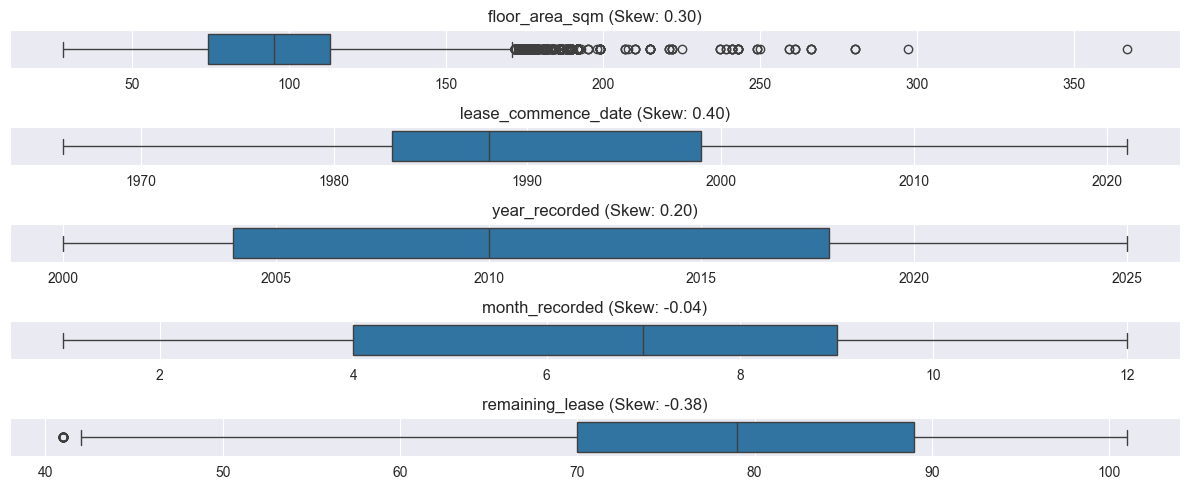

In [17]:

# Define numerical columns
numerical_cols = ['floor_area_sqm', 'lease_commence_date', 'year_recorded', 'month_recorded', 'remaining_lease']

fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=1, figsize=(12, 5), sharey=False)

# Generate horizontal boxplots for each feature with skewness in the title
for i, col in enumerate(numerical_cols):
    skewness = df[col].skew()  # Calculate skewness using pandas
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"{col} (Skew: {skewness:.2f})")  # Add skewness to title
    axes[i].set_xlabel("")  # Remove x-axis label for cleaner visualization

plt.tight_layout()  
plt.show()

In the graph above, we generated box plots for all our numerical predictor features. We have also calculated and labeled their respective skewness scores to their titles. From which we observe that: 
- floor area contains quite a few outliers with some even reaching > 350 sqm. However these may not be uncommon as houses usually do contain one or 2 that are quite significant in size. Its moderate positive skew is also unsuprising, as more houses tend to be smaller

- The positive skew suggests that most resales occurred in the earlier years, specifically between 2000 and 2015. This could be due to the data for 2025 only covering up to March, causing the later years to be underrepresented.

- Both year and month do not have outliers, indicating consistent and accurate data with no erroneous values.

- Finally remaining lease we see a moderate negative skew,  This suggests that most resales happen in the first 30 years of a HDB's lease. As the HDB ages past 30 years, fewer units are resold, likely due to the decreasing remaining lease and potentially less desirable units for buyers.


Based on the results above thereis little to no need to handle the outliers as they appear to be valid 

#### Sale Price 

Next we will look at the distribution for the target feature

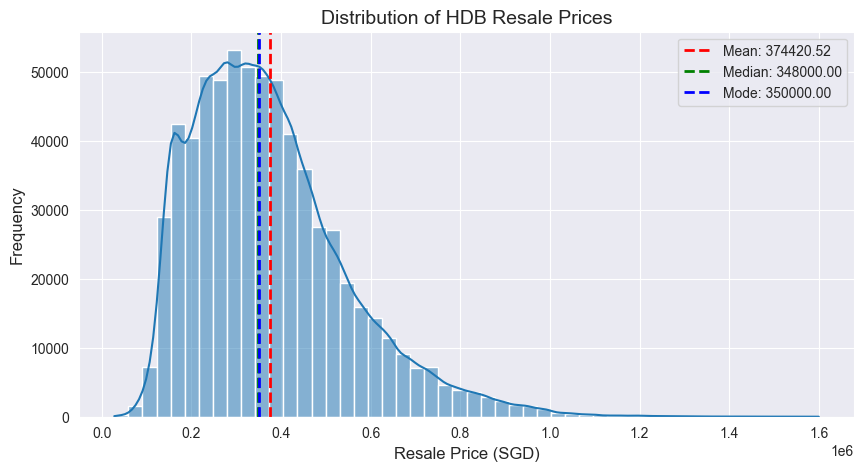

In [18]:
mean_price = df["resale_price"].mean()
median_price = df["resale_price"].median()
mode_price = df["resale_price"].mode()[0]  # Mode can return multiple values, take first

# Create histogram
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="resale_price", bins=50, kde=True)

# Plot vertical lines for mean, median, mode
plt.axvline(mean_price, color="red", linestyle="dashed", linewidth=2, label=f"Mean: {mean_price:.2f}")
plt.axvline(median_price, color="green", linestyle="dashed", linewidth=2, label=f"Median: {median_price:.2f}")
plt.axvline(mode_price, color="blue", linestyle="dashed", linewidth=2, label=f"Mode: {mode_price:.2f}")

# Titles & Labels
plt.title("Distribution of HDB Resale Prices", fontsize=14)
plt.xlabel("Resale Price (SGD)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.show()

In [19]:
print(f"Skewness score: {df['resale_price'].skew()}")

Skewness score: 1.0570945219718373


The histogram shows a positive skew in resale prices, with a skewness score of 1.05, indicating a few high values pulling the mean to the right. This skewness can affect model performance, especially for models like linear regression that assume normal distribution of the target variable.

Skewed data can also distort visualizations like correlation plots causing misinterpretation. To address this, we can apply a logarithmic transformation to reduce the skewness. Additionally, models less sensitive to outliers, like Lasso or Ridge regression, can be considered.

In [20]:
df['log_resale_price'] = np.log(df['resale_price'])
df.head(1)

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year_recorded,month_recorded,log_resale_price
0,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0000000,Improved,1986,"147,000.0000000",85,2000,1,11.8981879


By logging we are effectively re representing it as a proportion, allowing us to see the true correlation between 2 features

## EDA for Mall, MRT and HDB location dataset

Next we will also do some EDA for our Mall, MRT and HDB location dataset

In [21]:
print(mall_loc_df.columns)
print(mrt_loc_df.columns)
print(hdb_loc_df.columns)

Index(['mall', 'building', 'latitude', 'longitude'], dtype='object')
Index(['mrt', 'building', 'latitude', 'longitude', 'code'], dtype='object')
Index(['hdb', 'latitude', 'longitude'], dtype='object')


In our 3 location related datasets, we see that wer generally have the name of place and lat/long data

### Check datatypes
We will also do a quick check on the datasets datatypes

In [22]:
mall_loc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mall       174 non-null    object 
 1   building   174 non-null    object 
 2   latitude   174 non-null    float64
 3   longitude  174 non-null    float64
dtypes: float64(2), object(2)
memory usage: 5.6+ KB


In [23]:
mrt_loc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mrt        186 non-null    object 
 1   building   186 non-null    object 
 2   latitude   186 non-null    float64
 3   longitude  186 non-null    float64
 4   code       186 non-null    object 
dtypes: float64(2), object(3)
memory usage: 7.4+ KB


In [24]:
hdb_loc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9838 entries, 0 to 9837
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   hdb        9838 non-null   object 
 1   latitude   9838 non-null   float64
 2   longitude  9838 non-null   float64
dtypes: float64(2), object(1)
memory usage: 230.7+ KB


For all 3 of the locational datasets, we see that all of the data types are inorder, with 
- lat and long being float64s 
- hdb, mrt, building and mall being object dtypes

### Dataset Size 

In [25]:
print("mall", mall_loc_df.shape)
print("mrt", mrt_loc_df.shape)
print("hdb", hdb_loc_df.shape)

mall (174, 4)
mrt (186, 5)
hdb (9838, 3)


From the size, we see that we have info of 
- 174 different mall locations
- 186 different mrt locations
- 9838 different hdb locations

### Check for null values

In [26]:
print('Mall\n-------------------\n'+ str(mall_loc_df.isnull().sum()))
print('MRT\n-------------------\n'+ str(mrt_loc_df.isnull().sum()))
print('HDB\n-------------------\n'+ str(hdb_loc_df.isnull().sum()))

Mall
-------------------
mall         0
building     0
latitude     0
longitude    0
dtype: int64
MRT
-------------------
mrt          0
building     0
latitude     0
longitude    0
code         0
dtype: int64
HDB
-------------------
hdb          0
latitude     0
longitude    0
dtype: int64


We see that all of them do not have any null value, which is good

### Check for outliers
We should also check for outliers in our lat and long data, ensuring that our geolocation values are all within regions of Singapore. Here we created a function that will plot a scatterplot with SG's boundaries as a bounding box

In [27]:
def check_sg_geo_outliers(df, ax, title="Untitled Graph"):
    lat_min, lat_max = 1.130, 1.480
    long_min, long_max = 103.610, 104.080

    # Identify outliers
    df['outlier'] = ((df['latitude'] < lat_min) | (df['latitude'] > lat_max) |
                    (df['longitude'] < long_min) | (df['longitude'] > long_max))

    # For plotting
    outliers = df[df['outlier'] == True]
    valid_points = df[df['outlier'] == False]
    
    ax.scatter(data=valid_points, x='longitude', y='latitude', color='blue', label='Valid Points')
    ax.scatter(data=outliers, x='longitude', y='latitude', color='red', label='Outliers')

    # Plot Singapore boundary box
    ax.axhline(lat_min, color='gray', linestyle='dashed')
    ax.axhline(lat_max, color='gray', linestyle='dashed')
    ax.axvline(long_min, color='gray', linestyle='dashed')
    ax.axvline(long_max, color='gray', linestyle='dashed')

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(title)
    ax.legend()


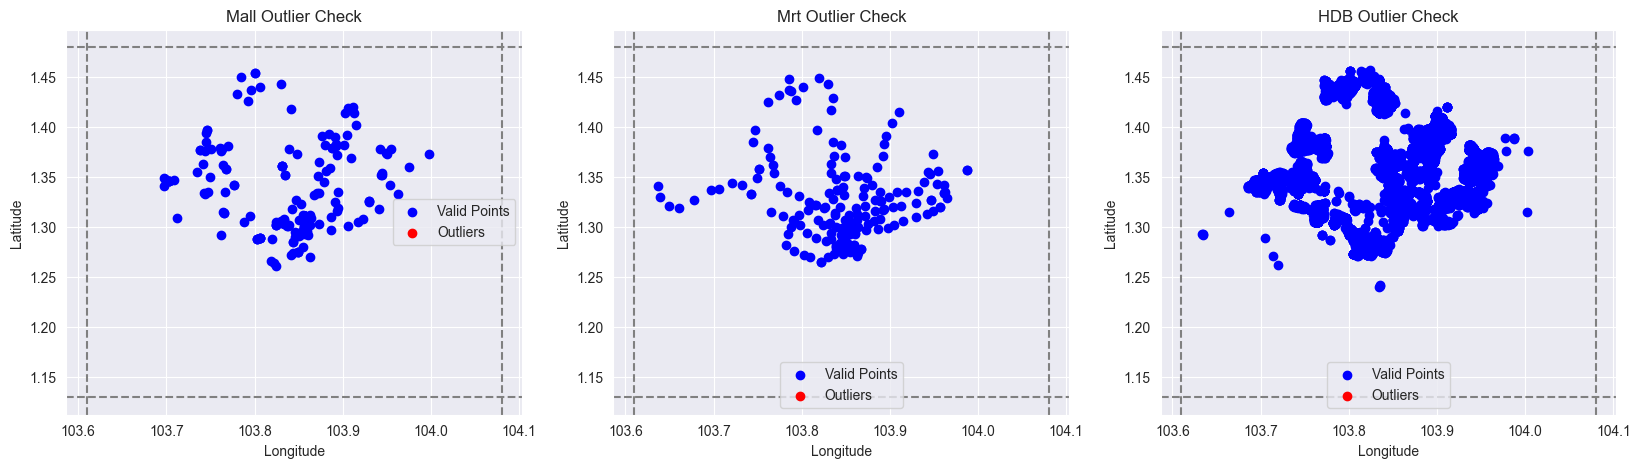

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
check_sg_geo_outliers(mall_loc_df, ax1, title="Mall Outlier Check")
check_sg_geo_outliers(mrt_loc_df, ax2,  title="Mrt Outlier Check")
check_sg_geo_outliers(hdb_loc_df, ax3, title="HDB Outlier Check")

From the plot above, we see that there are completely no outliers in our locational data for mall, mrt and hdbs, hence no action must be taken.

### Check for duplicates
We will also check for duplicates in the location datasets

In [29]:
duplicate_rows_df = mrt_loc_df[mrt_loc_df.duplicated()]
print('MRT', duplicate_rows_df.shape)

duplicate_rows_df = mall_loc_df[mall_loc_df.duplicated()]
print('Mall', duplicate_rows_df.shape)

duplicate_rows_df = hdb_loc_df[hdb_loc_df.duplicated()]
print('HDB', duplicate_rows_df.shape)

MRT (3, 6)
Mall (2, 5)
HDB (0, 4)


Here we see that there are 3 duplicates for MRT and 2 duplicates for Mall, while HDB has no duplicate rows. Since this is just locational data, we can simply just drop them 

In [30]:
mrt_loc_df.drop_duplicates(inplace=True)
mall_loc_df.drop_duplicates(inplace=True)
print('MRT', mrt_loc_df.shape)
print('Mall', mall_loc_df.shape)


MRT (183, 6)
Mall (172, 5)


### Distance between HDB - Mall and MRT

We can calculate the distance to the nearest MRT station or mall for each home using the coordinates from earlier. Our hypothesis is that proximity to these amenities will affect resale prices, as greater convenience increases demand. To do this, we'll use geopy's great-circle tool to compute the distance between points based on latitude and longitude.

<img src='https://www.caliper.com/glossary/xmaptitude-great-circle-map.jpg.pagespeed.ic.he9JED27BN.webp'></img>

In [31]:
from geopy.distance import great_circle

address =[]
d_mrt = []
n_mrt = []
d_mall = []
n_mall = []

for add,lat,lon in tqdm(zip(hdb_loc_df.hdb,hdb_loc_df.latitude,hdb_loc_df.longitude), desc="Fetching Nearest Ammenities"):
    d_to_mrt = 99
    d_to_mall = 99
    temp = 0
    
    #loop for MRT and Mall to find the shortest distance to address
    for mrt,mrt_lat,mrt_lon in zip(mrt_loc_df.building, mrt_loc_df.latitude, mrt_loc_df.longitude):
        temp = great_circle((lat, lon), (mrt_lat, mrt_lon)).km
        if d_to_mrt > temp:
            d_to_mrt = temp
            n_to_mrt = mrt
    for mall,mall_lat,mall_lon in zip(mall_loc_df.mall, mall_loc_df.latitude, mall_loc_df.longitude):
        temp = great_circle((lat, lon), (mall_lat, mall_lon)).km
        if d_to_mall > temp:
            d_to_mall = temp  
            n_to_mall = mall
    
    address.append(add)
    d_mrt.append(d_to_mrt)
    n_mrt.append(n_to_mrt)
    d_mall.append(d_to_mall)
    n_mall.append(n_to_mall)
    
hdb_loc_df['dist_mrt'] = d_mrt
hdb_loc_df['near_mrt'] = n_mrt
hdb_loc_df['dist_mall'] = d_mall
hdb_loc_df['near_mall'] = n_mall

Fetching Nearest Ammenities: 9838it [00:54, 180.57it/s]


In [32]:
df['address'] = df['block'] + ' ' + df['street_name'] + ' '+ 'SINGAPORE'
merged_df = pd.merge(df, hdb_loc_df, how='left', left_on='address', right_on='hdb')
# Drop the redundant 'hdb' column if needed
merged_df.drop(columns=['hdb', 'outlier'], inplace=True)
merged_df.head(2)

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year_recorded,month_recorded,log_resale_price,address,latitude,longitude,dist_mrt,near_mrt,dist_mall,near_mall
0,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0000000,Improved,1986,"147,000.0000000",85,2000,1,11.8981879,170 ANG MO KIO AVE 4 SINGAPORE,1.3791499,103.8409382,0.5315847,YIO CHU KANG MRT STATION (NS15),0.2604689,AMK Hub
1,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0000000,Improved,1986,"144,000.0000000",85,2000,1,11.8775686,174 ANG MO KIO AVE 4 SINGAPORE,1.3791499,103.8409382,0.5315847,YIO CHU KANG MRT STATION (NS15),0.2604689,AMK Hub


### Extract middle, upper and lower bounds of storey range 
Another column that needs handling would be the storey range feature, which indicates the lower and upper bound range that each house is in. Initially we thought that the house storeys would be in consistent intervals of 3 levels like 07 to 09, but there see to be some with larger ranges like 06 to 10.  

In [33]:
merged_df['storey_range'].unique()

array(['07 TO 09', '04 TO 06', '01 TO 03', '10 TO 12', '13 TO 15',
       '16 TO 18', '19 TO 21', '22 TO 24', '25 TO 27', '28 TO 30',
       '31 TO 33', '40 TO 42', '37 TO 39', '34 TO 36', '46 TO 48',
       '43 TO 45', '49 TO 51', '06 TO 10', '01 TO 05', '11 TO 15',
       '16 TO 20', '21 TO 25', '26 TO 30', '36 TO 40', '31 TO 35'],
      dtype=object)

So we have decided to extract the upper, lower and middle of the stories for each range. Upper and lower will be used for ML as it retains information that is more pure, but the middle will only be used for visualisation as it is easier to analyse

In [34]:
# Extract the lower and upper bounds using regex (faster than apply)
merged_df[['storey_lower', 'storey_upper']] = merged_df['storey_range'].str.extract(r'(\d+) TO (\d+)').astype(int)

# Compute the middle storey in a vectorized way
merged_df['storey_middle'] = (merged_df['storey_lower'] + merged_df['storey_upper']) // 2
merged_df.drop(['storey_range'], axis=1, inplace=True)
# Display the updated DataFrame
merged_df.head(2)


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year_recorded,...,address,latitude,longitude,dist_mrt,near_mrt,dist_mall,near_mall,storey_lower,storey_upper,storey_middle
0,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,69.0000000,Improved,1986,"147,000.0000000",85,2000,...,170 ANG MO KIO AVE 4 SINGAPORE,1.3791499,103.8409382,0.5315847,YIO CHU KANG MRT STATION (NS15),0.2604689,AMK Hub,7,9,8
1,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,61.0000000,Improved,1986,"144,000.0000000",85,2000,...,174 ANG MO KIO AVE 4 SINGAPORE,1.3791499,103.8409382,0.5315847,YIO CHU KANG MRT STATION (NS15),0.2604689,AMK Hub,4,6,5


In [35]:
merged_df.columns

Index(['town', 'flat_type', 'block', 'street_name', 'floor_area_sqm',
       'flat_model', 'lease_commence_date', 'resale_price', 'remaining_lease',
       'year_recorded', 'month_recorded', 'log_resale_price', 'address',
       'latitude', 'longitude', 'dist_mrt', 'near_mrt', 'dist_mall',
       'near_mall', 'storey_lower', 'storey_upper', 'storey_middle'],
      dtype='object')

## Data Visualization and Story telling

Our target audience includes HDB resellers, and our aim is to educate them on the various factors that influence HDB housing prices as well as its current market enviroment. This section will focus on providing valuable insights to help them understand these aspects.

### What affects the price

When buying or selling a resale flat, one of the first questions that comes to mind is: What determines its price? Beyond just numbers, how can homeowners understand the perks and disadvantages of their own flats?

Hence, to study this, let’s delve into the data using the plots we have prepared for this section

#### Resale Price vs Flat Type 

The first visuals that we have prepared consist of a box plot that shows the distributions of resale price split between flat types (1 Room, 2 Room...)

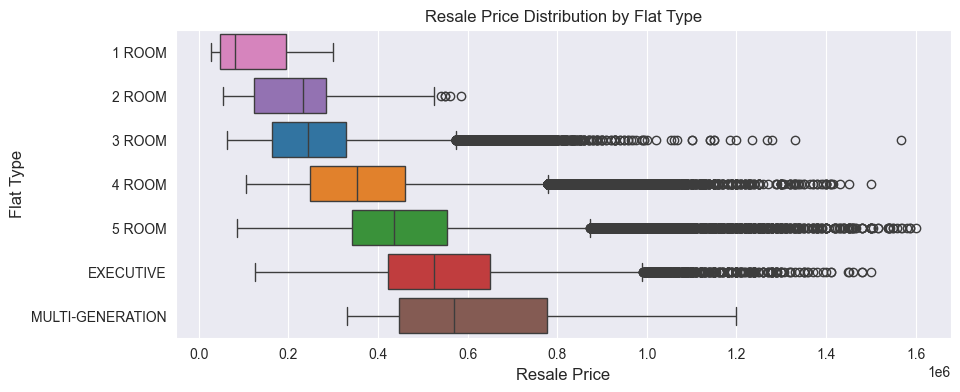

In [36]:
plt.figure(figsize=(10, 4))

ordered_flat_types = ['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']

# Boxplot for resale price by flat type
sns.boxplot(data=merged_df, x='resale_price', y='flat_type', hue='flat_type', order=ordered_flat_types,)
plt.title('Resale Price Distribution by Flat Type', fontsize=12)
plt.xlabel('Resale Price', fontsize=12)
plt.ylabel('Flat Type', fontsize=12)


plt.show()


While its no surprise that bigger flats (5-room, Executive) generally cost more than smaller ones (1-room, 2-room). The boxplot tells us an interesting story! Based on the results we obsere that

- As expected, we see a clear distribution trend for flat types, where the number of rooms generally correlates with higher resale prices. However, the trend is not as straightforward as expected, as we observe significant overlap where \some smaller flats are even priced higher than larger ones.

- This suggests that while flat type does matter, sellers shouldn’t assume they’ll get a high price just because they own a 5-room flat. Other factors are at play.

- It teaches us that there is more at play here 

#### Resale Price vs Flat Model

Next we also decided to tackle the flat model's effect on resale price

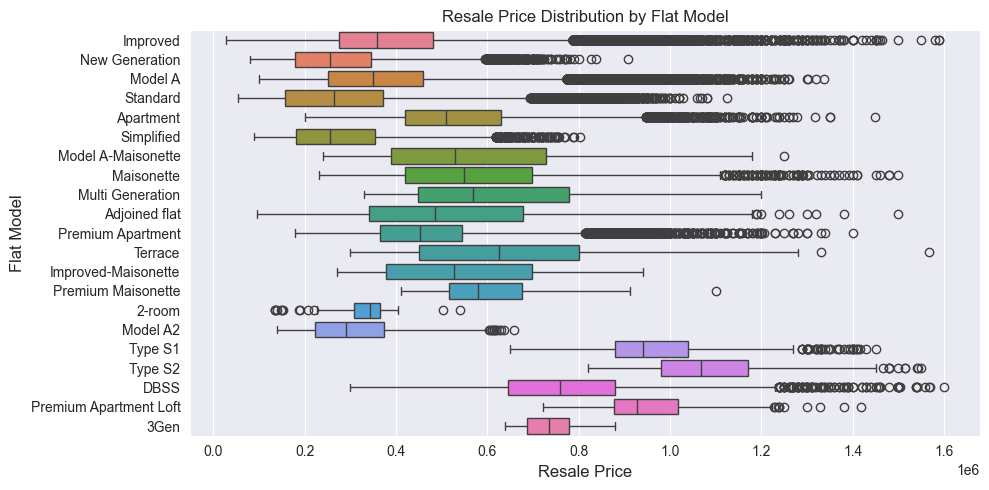

In [76]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=merged_df, x='resale_price', y='flat_model', hue='flat_model')
plt.title('Resale Price Distribution by Flat Model', fontsize=12)
plt.xlabel('Resale Price', fontsize=12)
plt.ylabel('Flat Model', fontsize=12)
plt.tight_layout()
plt.show()


This plot however shows a different story. It does not show any strong signs of trend/split and contains tons of overlap. However we do see some segregation between TypeS1, S2, DBSS, Premium apartment lofts and 3gen housing from the rest of the models.

Research reveals that these are more premium projects:
- Type S1 and S2 are from The Pinnacle, an expensive HDB project.
- DBSS Flats are private-design, exclusive homes.
- Premium Apartment Lofts are 2-story HDBs with large living areas.
- 3Gen housing caters to multi-generational families with larger living spaces.


So unless your house is any of these premium options ^, the model of your house is not a driving factor in its potential resale price

#### Correlational Analysis

Up next on what affects the price is an indepth correlation analysis for our continuous variables. The plot consists of scatterplots relating to the following features 
- remaining lease 
- floor area 
- distance from mall
- distance from mrt
- storey
- year recorded

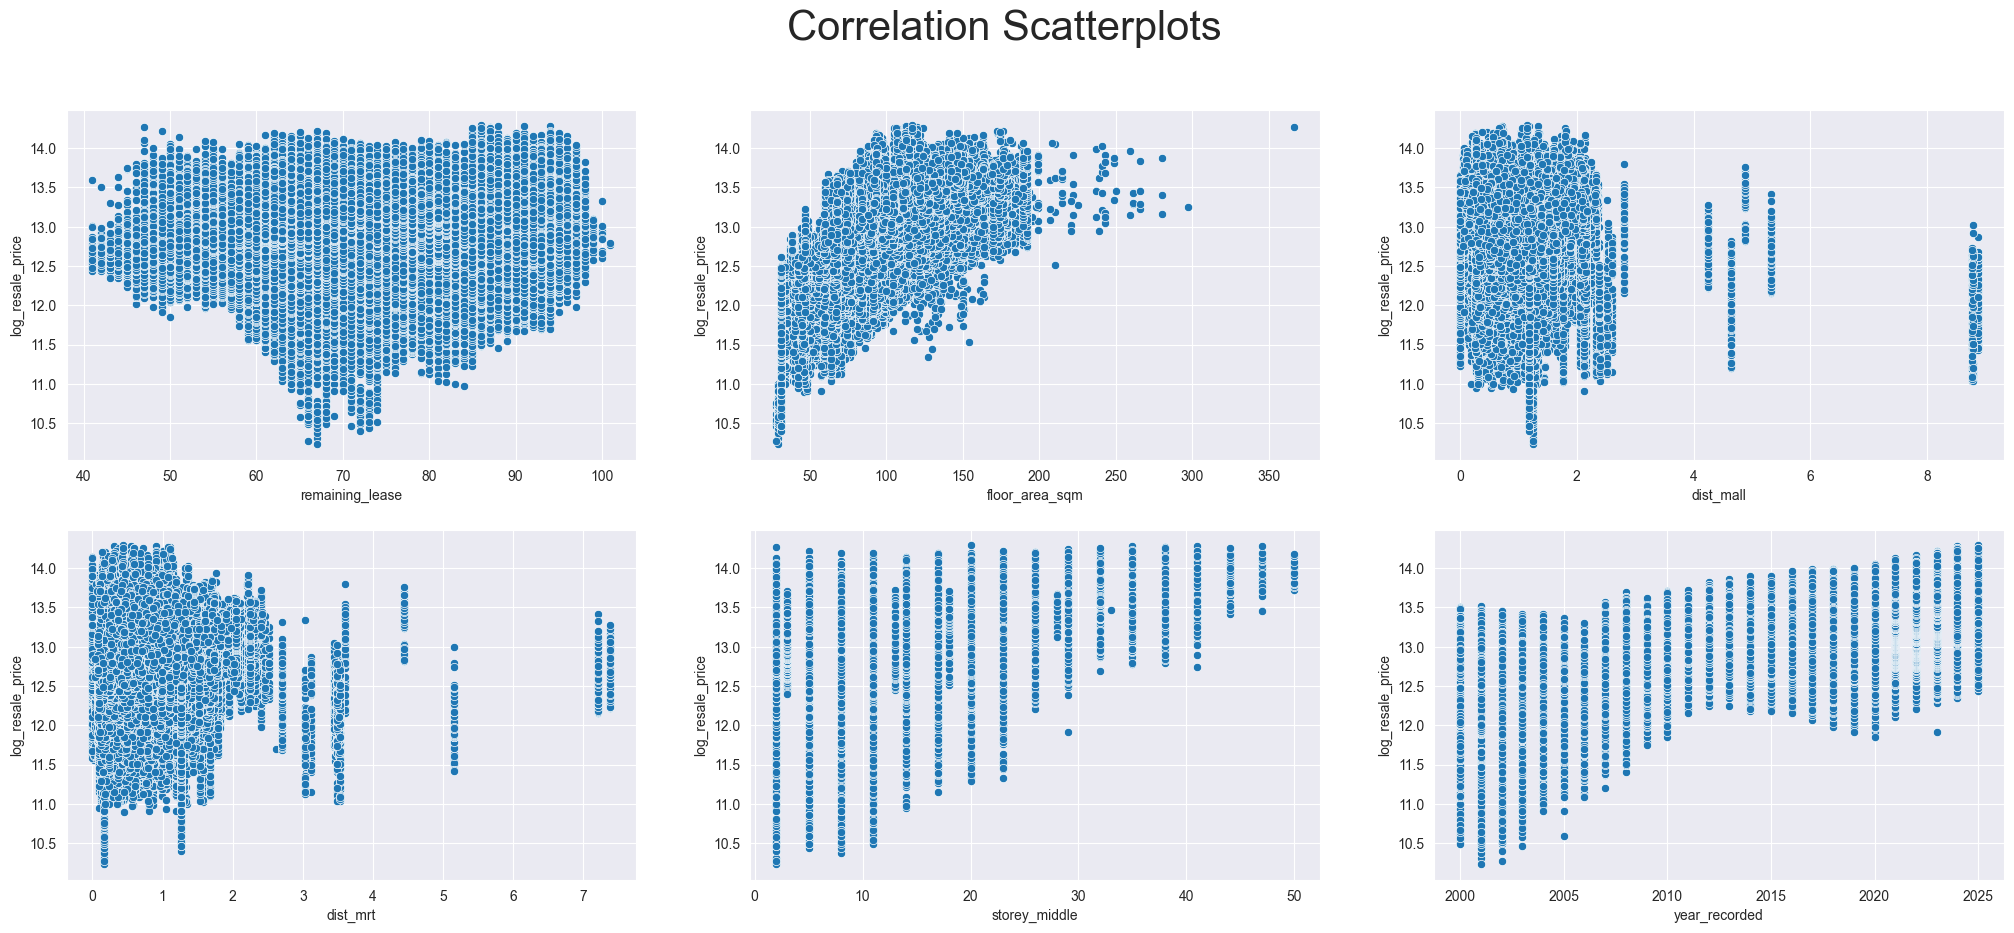

In [41]:
fig, ((ax1,ax2,ax3),(ax4, ax5, ax6)) = plt.subplots(2,3,figsize=(25, 10))
num_ds = merged_df[['remaining_lease', 'floor_area_sqm', 'dist_mall', 'dist_mrt' , 'storey_middle','log_resale_price', 'year_recorded']]

# Create the scatter plot within the subplot

sns.scatterplot(data = num_ds, x='remaining_lease', y='log_resale_price', ax=ax1)
sns.scatterplot(data = num_ds, x='floor_area_sqm', y='log_resale_price', ax=ax2)
sns.scatterplot(data = num_ds, x='dist_mall', y='log_resale_price', ax=ax3)
sns.scatterplot(data = num_ds, x='dist_mrt', y='log_resale_price', ax=ax4)
sns.scatterplot(data = num_ds, x='storey_middle', y='log_resale_price', ax=ax5)
sns.scatterplot(data = num_ds, x='year_recorded', y='log_resale_price', ax=ax6)
fig.suptitle('Correlation Scatterplots', fontsize=30)

# Show the plot
plt.show()

From the results above, some of the features show a level of positive correlation to the resale price while others not so much. We see that 
- Remaining lease, dist mrt and dist mall show little to no correlation to the resale price. Such results do not confirm that the feature is useless but it could be a sign of poor or improper data representation, where the relationship may not be linear.

- Things that do however show positive correlations would be the floor area, storey and year recorded. These are things  make sense and are predictable like larger housing, higher floors and inflation all driving up the price. However we want to look beyond the correlation

- For instance looking at the storey, we see that the top left triangle is filled but bottom is empty.  This suggests that while the storey level can vary significantly, each storey seems to have a base price that remains relatively consistent, regardless of the specific flat. By understanding this trend, resellers can strategically price their units based on the storey they’re selling, ensuring they align with the market’s expectations

- Another interesting idea is the correlation between year recorded and resale price. This positive increase per year gives insight into inflation of SG house pricing. This may be a factor that has been influencing our other feature correlations


#### Inflation Factored Correlation heat map

To enhance to study on feature relations, we can factor out the inflation rate by plotting seperate heatmaps for each year and for each feature

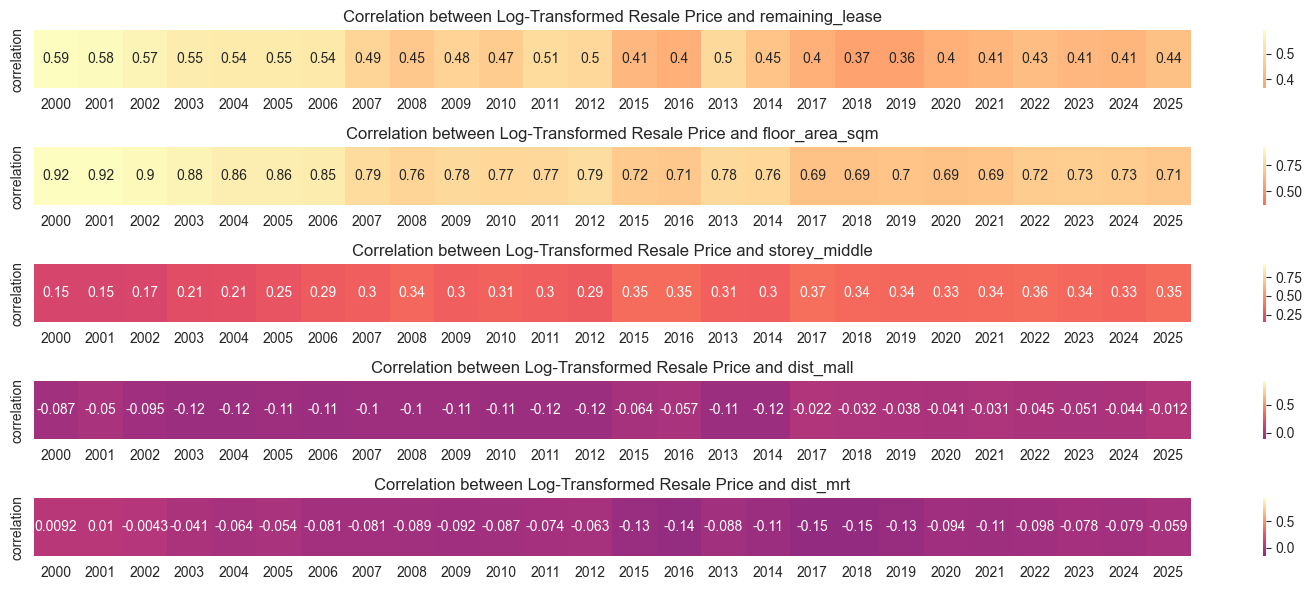

In [56]:
variables = ['remaining_lease', 'floor_area_sqm', 'storey_middle', 'dist_mall', 'dist_mrt']
fig, axes = plt.subplots(5, 1, figsize=(15, 6))
all_corr_vals = []

# Loop through each variable to generate heatmaps
for idx, var in enumerate(variables):
    heat = pd.DataFrame({'correlation': []})
    
    # Loop through each unique year and calculate the correlation
    for year in merged_df['year_recorded'].unique():
        year_df = merged_df[merged_df['year_recorded'] == year].copy()
        corr_val = year_df[['log_resale_price', var]].corr().iloc[0, 1]
        heat.loc[year] = corr_val  
    all_corr_vals.append(heat['correlation'])
    # Plot heatmap for the current variable
    sns.heatmap(heat.T, annot=True, center=0, ax=axes[idx], cmap='magma', vmin=np.min(all_corr_vals), vmax=np.max(all_corr_vals))

    axes[idx].set_title(f"Correlation between Log-Transformed Resale Price and {var}")

plt.tight_layout()
plt.show()


Now we can truly see correlation for what it is.
- We observe that remaining lease, floor area and storey have become significantly stronger in its correlations while distance to mall and mrt are still very weak
- We also get to view market shift in feature importance. From the plots we see that remaining lease and floor area have become slightly less important in resale price evaluation, while storey has become more significant. 
- This market shift gives insight to what buyers are now looking out for in recent times and are valuable to resellers as they can adjust their resale prices to fit current market demand.

### When to Resell? 

Reselling a HDB doesn’t just involve deciding on the right price to sell it at. Resellers must also consider the optimal time to sell in order to achieve the best returns. For those looking to invest in resale HDBs, understanding the ideal age of a flat to purchase is just as important.

Hence the following analyses provide insight on these:

#### Remaining Lease analysis
To figure out which age to sell my hdb, it is important that we look at the remaining lease distribution plot as it gaueges the resale activity for houses of different ages


Text(0.5, 1.0, 'Remaining Lease distribution')

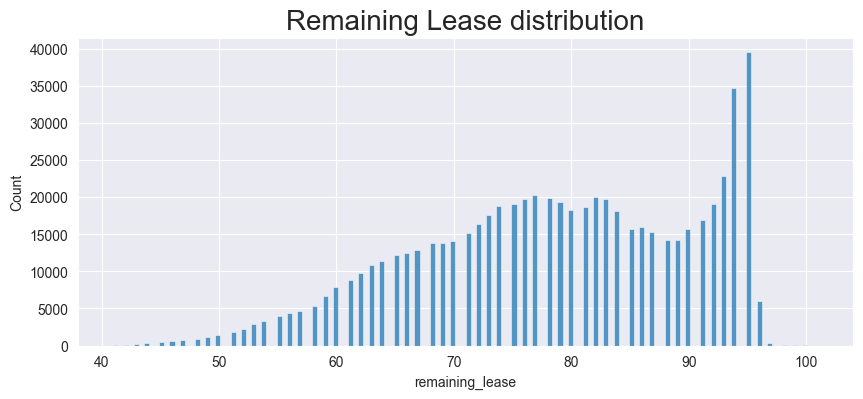

In [42]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 4))
sns.histplot(data=merged_df, x='remaining_lease', ax=ax1)
plt.title('Remaining Lease distribution', fontsize=20)

The historgram above shows a negatively skewed distribution, indicating that most resale activity happens during the first 30 years of a HDBs commencement. We see that the most resale activity occurs when the flat is about 93-95 years old. is suggests that many first-time owners are looking to sell their property around this age, likely to capitalize on the future demand from potential buyers who are aiming to benefit from reselling in the coming years.

Reselling activity remains relatively high between 75 to 99 years of a HDB's lifecycle but begins to taper off as the flat’s age decreases further, especially around the 45-year mark. This behavior can be attributed to a loss of confidence in the resale market, as the property now carries a higher risk of being called for demolition. This reduces its competitiveness in the resale market. Sellers at this stage are likely individuals trying their luck to secure a better premium before the property is potentially acquired by the government.

**Advice for resellers:** It's generally advisable to sell within the first 30 years of a HDB's lifecycle, as this period offers higher competition and greater opportunities for successful resales at higher premiums.


**Advice for buyers:** It's generally advisable to buy resale HDBs with about 10 to 20 years remaining before they reach 75 years old. This timeframe allows you to capitalize on potential resale opportunities, while also giving you a chance to secure the best bargain due to higher competition in the market. However, if you're not interested in reselling or if you're approaching retirement age, the lease remaining may not be as important a factor in your decision-making.

#### Average Month analysis

Something else that can affect when to buy is the month of the year, hence to check that we calculated the average resales per month across all years

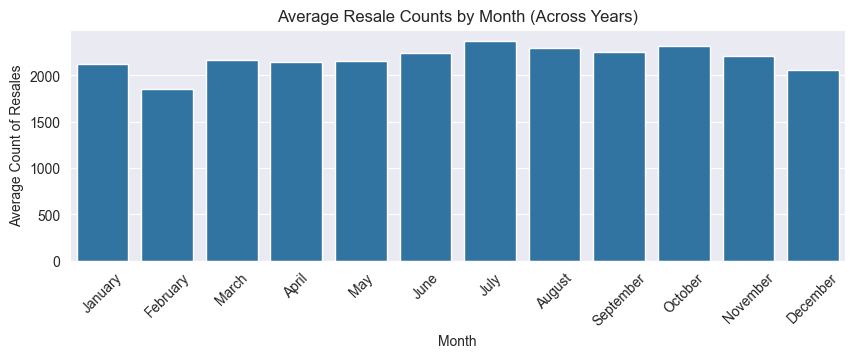

In [44]:
a = merged_df[['year_recorded', 'month_recorded', 'resale_price']]
result = a.groupby(['year_recorded', 'month_recorded']).count().reset_index()
monthly_avg_resales = result.groupby('month_recorded')['resale_price'].mean().reset_index()
monthly_avg_resales = monthly_avg_resales.rename(columns={'month_recorded': 'Month', 'resale_price': 'Average_Resales'})
month_map = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

monthly_avg_resales['Month'] = monthly_avg_resales['Month'].map(month_map)
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_avg_resales['Month'] = pd.Categorical(monthly_avg_resales['Month'], categories=month_order, ordered=True)
monthly_avg_resales = monthly_avg_resales.sort_values('Month')

plt.figure(figsize=(10, 3))
sns.barplot(x='Month', y='Average_Resales', data=monthly_avg_resales)
plt.xlabel('Month')
plt.ylabel('Average Count of Resales')
plt.title('Average Resale Counts by Month (Across Years)')
plt.xticks(rotation=45)  
plt.show()



Based on the plot above we see only slight variations in resale counts across all months for all years. But we do see that the months with lower number of resales include february and december, whilst there is a slight increase from June to October

Some possible explanations for this would be that 
-  Feb marks Chinese New Year where many people prioritize family, traditions, and celebrations over making significant financial or real estate decisions. 

- During months like June to October, families with children may choose to move after school terms end, creating a peak in resale activity. This time might also be favored for relocation due to school or job-related reasons.

Although the fluctuations are not dramatic, resellers can still capitalize on these subtle shifts in activity. By timing their listings for these peak periods, they can increase their chances of catching the slight increase in resale traffic, especially during the more favorable months like June to October as well as avoid lower traffic months like february.

### HDB Geo analysis
This section covers more locational insights for HDBs, things that relate to the geospatial data we have collected

For the analysis below, we selected the most insightful analyses. 

However, preparation was essential, involving multiple feature aggregates like median resale price, number of resales, mall and MRT distances, and the correlation between floor area and resale price. Not all data was used in the final analysis.

In [45]:
# Get aggregate data
town_agg_df = merged_df.groupby('town').agg(
    median_resale_price=('resale_price', 'median'),
    count_resale_price=('resale_price', 'count'),
    dist_mrt=('dist_mrt', 'mean'),
    dist_mall=('dist_mall', 'mean'),
    lease_commence_date=('lease_commence_date', 'mean'),
    floor_area=('floor_area_sqm', 'median')
).reset_index()

# Fix some null values
town_agg_df.loc[town_agg_df['town'] == 'KALLANG/WHAMPOA', 'town'] = 'KALLANG'
town_agg_df.loc[town_agg_df['town'] == 'CENTRAL AREA', 'town'] = 'DOWNTOWN CORE'

# Rename to fit geo json identifiers
town_agg_df['planning_area'] = town_agg_df['town'].apply(lambda x: x.title())
with open('./datasets/district_and_planning_area.geojson') as f:
    geojson_data = json.load(f)

# Merge geo json district properties
district_dict = {}
l = []
for i in geojson_data['features']:
    district_dict[i['properties']['planning_area']] = i['properties']['district']

# Fill Na central cuz tested before the there are 2 areas from central with NaN
town_agg_df['district'] = town_agg_df['planning_area'].map(district_dict).fillna('Central')
corr_df = pd.DataFrame({
    'town': [],
    'corr_resale_commence': []
})

# Calculte correlation individually for each town
for town in merged_df['town'].unique():
    town_data = merged_df[merged_df['town'] == town]
    corr_value =town_data[['log_resale_price', 'floor_area_sqm']].corr().iloc[0,1]
    new = pd.DataFrame({
        'town': [town],
        'corr_resale_commence': [corr_value]
    })

    corr_df = pd.concat([corr_df, new], ignore_index=True)

town_agg_df = town_agg_df.merge(corr_df)

# Merge and scale everything to have same 0 - 1 range for color intensity representation
scaler = MinMaxScaler()
df_scaled = town_agg_df.copy()
columns = ['median_resale_price', 'count_resale_price', 'dist_mrt', 'dist_mall', 'lease_commence_date', 'floor_area', 'corr_resale_commence']
df_scaled[columns] = scaler.fit_transform(town_agg_df[columns])

df_scaled.head()

,town,median_resale_price,count_resale_price,dist_mrt,dist_mall,lease_commence_date,floor_area,planning_area,district,corr_resale_commence
0,ANG MO KIO,0.0105263,0.5527430,0.1119459,0.2259727,0.1947649,0.1403509,Ang Mo Kio,North-East,0.7973877
1,BEDOK,0.0947368,0.6964049,0.3091777,0.6109812,0.2292535,0.3157895,Bedok,East,0.8476057
2,BISHAN,0.7894737,0.2080657,0.4396491,1.0000000,0.3942088,0.6842105,Bishan,Central,0.8297786
3,BUKIT BATOK,0.1052632,0.4966453,0.3822152,0.3862065,0.4414400,0.4561404,Bukit Batok,West,0.7796920
4,BUKIT MERAH,0.5000000,0.4111621,0.3157163,0.5525646,0.3163995,0.3157895,Bukit Merah,Central,0.9460555


We also took the mrt station data, and decided to include it in our choropleths to identify any potential relations it has to our resale price 

In [46]:
def map_mrt_line(mrt_code):
    if mrt_code.startswith('NS'):
        return 'North-South'
    elif mrt_code.startswith('TE'):
        return 'Thompson-East'
    elif mrt_code.startswith('NE'):
        return 'North-East'
    elif mrt_code.startswith('EW'):
        return 'East-West'
    elif mrt_code.startswith('CC'):
        return 'Circle'
    elif mrt_code.startswith('DT'):
        return 'Downtown'
    elif mrt_code.startswith('CG'):
        return 'East-West'
    elif mrt_code.startswith('CE'):
        return 'Circle'
    else:
        return np.nan   # In case the code doesn't match any prefix

# Apply the function to the 'mrt_code' column to create the 'line_name' column
mrt_loc_df['line'] = mrt_loc_df['code'].apply(map_mrt_line)
# View the updated dataframe
mrt_loc_df = mrt_loc_df.drop_duplicates(subset=['mrt'])



We then used a library known as folium for geo location handling and plotting choropleths maps. For this we used a geojson file found online for SG district and planning which gives us all of the district location info, and plotted the data accordingly. 

#### Correlation between floor sqm and resale price separated by region
We all know that the size of your home is a significant driving force for the resale price of our HDBs, but more can actually be uncovered about their reationship. 

By splitting the correlation, we get to see the strength of this feature in driving resale price for each town in SG

In [48]:
f = folium.Figure(width=1200, height=800)
m = folium.Map(location=[1.350270, 103.81959], zoom_start=11).add_to(f)

c = folium.Choropleth(
    geo_data=geojson_data,
    data=(zip(df_scaled['planning_area'], df_scaled['corr_resale_commence'])),
    key_on="feature.properties.planning_area",
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
).add_to(m)

line_colors = {
    'North-South': 'red',
    'Thompson-East': 'black',
    'North-East': 'purple',
    'East-West': 'green',
    'Circle': 'orange',
    'Downtown': 'blue'
}


# Add planning area labels
for feature in geojson_data['features']:
    planning_area = feature['properties']['planning_area']
    geom = shape(feature['geometry'])
    centroid = geom.centroid.coords[0]

    folium.Marker(
        location=[centroid[1], centroid[0] - 0.01],  
        icon=folium.DivIcon(html=f'''
            <div style="text-align: center; font-size: 10px; font-weight: bold; color: black; width: 100px;">
                {planning_area}
            </div>
        ''')
    ).add_to(m)

f
    

Based on the map, we observe an interesting trend: the correlation between floor area and resale price weakens as we move away from central Singapore. This could be due to the higher availability of housing in the outer areas, as the central region is more densely developed with city hub projects. In these central areas, floor area becomes a more contested resource, leading to higher resale prices.

Resellers in specific areas can benefit by pricing their properties based on location. In central areas, they can emphasize limited space to command higher prices. 

#### Effect of Town and Resale Price 
Next we also wanted to look at how town affects the resale price itself. But since there were so many towns, it was hard to plot using a box plot so here we will use a choropleth to see if we can obtain any insights

In [49]:
f = folium.Figure(width=1200, height=800)
m = folium.Map(location=[1.350270, 103.81959], zoom_start=11).add_to(f)

c = folium.Choropleth(
    geo_data=geojson_data,
    data=(zip(df_scaled['planning_area'], df_scaled['median_resale_price'])),
    key_on="feature.properties.planning_area",
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
).add_to(m)

line_colors = {
    'North-South': 'red',
    'Thompson-East': 'black',
    'North-East': 'purple',
    'East-West': 'green',
    'Circle': 'orange',
    'Downtown': 'blue'
}


# Add planning area labels
for feature in geojson_data['features']:
    planning_area = feature['properties']['planning_area']
    geom = shape(feature['geometry'])
    centroid = geom.centroid.coords[0]

    folium.Marker(
        location=[centroid[1], centroid[0] - 0.01],  
        icon=folium.DivIcon(html=f'''
            <div style="text-align: center; font-size: 10px; font-weight: bold; color: black; width: 100px;">
                {planning_area}
            </div>
        ''')
    ).add_to(m)

m

The regional effect on home pricing shows that homes tend to be more expensive in certain towns, particularly those concentrated from the central to the northeast areas. This pricing pattern can be attributed to factors such as:

- Perception of the west being more "ulu" (remote or less developed).
- Higher concentration of amenities in the eastern regions.
- Areas like Bukit Timah and 6 Avenue, which are known for their higher-cost residences.
- More recent developments in these areas.

Seeing that  these regions tend to have higher resale prices, hdb buyers can consider purchasing or targeting properties from the government in these areas to take advantage of higher demand and pricing, for future resale. 


## Machine Learning

Before proceeding to train our models, we need to prepare our dataset first and make sure that it in the state that allows the models to preprocess the data in the dataset. Our goal here is transform the categorical data into numeric format, and also to remove unnecessary columns that does not help in evaluating our results (such as columns that contains text).

In [61]:
ml_df = merged_df.copy()
ml_df.drop(columns = ['block', 'street_name'], axis=1, inplace=True)
ml_df.head()
flat_type_order = {
    '1 ROOM': 1,
    '2 ROOM': 2,
    '3 ROOM': 3,
    '4 ROOM': 4,
    '5 ROOM': 5,
    'EXECUTIVE': 6,
    'MULTI-GENERATION': 7
}
ml_df['flat_type_encoded'] = ml_df['flat_type'].map(flat_type_order)
df_encoded = pd.get_dummies(ml_df, columns=['flat_model'], prefix='model', dtype=int)
df_encoded = pd.get_dummies(df_encoded, columns=['town'], prefix='town', dtype=int)

df_encoded.drop(['flat_type', 'lease_commence_date', 'year_recorded', 'resale_price', 'address',  'storey_middle', 'near_mrt', 'near_mall'], axis=1, inplace = True)

# change month_recorded to numeric
df_encoded['month_recorded'] = df_encoded['month_recorded'].astype(int)
df_encoded.head(2)

,floor_area_sqm,remaining_lease,month_recorded,log_resale_price,latitude,longitude,dist_mrt,dist_mall,storey_lower,storey_upper,...,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN
0,69.0000000,85,1,11.8981879,1.3791499,103.8409382,0.5315847,0.2604689,7,9,...,0,0,0,0,0,0,0,0,0,0
1,61.0000000,85,1,11.8775686,1.3791499,103.8409382,0.5315847,0.2604689,4,6,...,0,0,0,0,0,0,0,0,0,0


Firstly, we dropped `block` and `street_name` as they are not useful in helping us predict the resale prices, since they are unique and only contributes to adding noise instead of identifying a pattern.

We also encoded `flat_type` to numerical format from categorical as it has an ordinal relationship (e.g 5 room flats are bigger than 3 room flats, etc.) using a predefined ordinal mapping, so that it preserves its order and also making it suitable to feed to our ML models.

One-Hot Encoding was also applied to `flat_model` and `town` as they are categorical but do not possess any intrinsic order, the transformation are as follows:
- 1 indicating belongs to that category
- 0 indicating does not belong to that category
As they are categorical but unordered data, encoding it would help the ML models intepret these categories correctly.

Finally, we also decided to drop the redundant columns to further clean our data and prepare for machine learning, which includes:
- `flat_type` as it is already represented by `flat_typed_encoded`
- `lease_commence_date` & `year_recorded` as those were previously used to calculate `remaining_lease`
- `resale_price`, `address`, `storey_middle`, `near_mrt`, `near_mall` as those would not be used as inputs or help in the predictions

`month_recorded` was also converted to int as it was previously identified to be an object, which would cause an error as well.

Now that our dataset is clean, numerically formatted, we are ready to use `df_encoded` as our dataframe to train our machine learning models.

In [62]:
df_encoded.columns

Index(['floor_area_sqm', 'remaining_lease', 'month_recorded',
       'log_resale_price', 'latitude', 'longitude', 'dist_mrt', 'dist_mall',
       'storey_lower', 'storey_upper', 'flat_type_encoded', 'model_2-room',
       'model_3Gen', 'model_Adjoined flat', 'model_Apartment', 'model_DBSS',
       'model_Improved', 'model_Improved-Maisonette', 'model_Maisonette',
       'model_Model A', 'model_Model A-Maisonette', 'model_Model A2',
       'model_Multi Generation', 'model_New Generation',
       'model_Premium Apartment', 'model_Premium Apartment Loft',
       'model_Premium Maisonette', 'model_Simplified', 'model_Standard',
       'model_Terrace', 'model_Type S1', 'model_Type S2', 'town_ANG MO KIO',
       'town_BEDOK', 'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH',
       'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA',
       'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPO

From the above columns, we see that our dataset is ready to be use for machine learning, as it is now fully cleaned.

### Train Validate Test

For this study, we decided to employ a train validate test strategy to evaluate our model perfromance in-place of the simple train test split used in our curriculum. This is due to the later part of our study where we employ GridSearchCV for our hyperparameter tuning. 

Through our research, we understood the risk of data leakage, which can occur if the test set is used for model tuning. This can introduce bias into our evaluation metrics, leading to an overly optimistic view of the model's performance. To avoid this, we use a separate validation set for hyperparameter tuning and reserve the test set solely for final evaluation, ensuring a more accurate and unbiased assessment of model performance.

In [63]:
# preparation for train-validation-test split
target = "log_resale_price"
features = [col for col in df_encoded.columns if col != target]

# train-validation-test split [training (70%), validation (15%), and testing (15%)]
X_train, X_test, y_train, y_test = train_test_split(df_encoded[features], df_encoded[target], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

### Base Model Training
Now we will evaluate and look at how well different machine learning models perform on our dataset before any tuning or optimization. The goal is to establish baseline performances so that we can improve the performances through hyperparameter tuning and model refinement later. 

Since our target variable (`resale_price`) was tampered (log) during preprocessing, we needed to convert the predictions and true values back to their original scale using the exponential function, to ensure that performance metrics like RMSE, MAE, and R² are interpreted in their actual price values.

We tried out 3 models:
#### Linear Regression
is used to predict the value of our target variable (`log_resale_price`) based on linear relationships between the input features (X) and the target (y) by fitting a straight line. The key purpose of linear regression is to estimate the strength of the relationship between X and our target variable. It helps us understand, on average, how much `log_resale_price` changes in response to a one-unit change in a given feature, assuming all other features remain constant. This makes it a valuable baseline model for interpretability and initial performance benchmarking

#### Random Forest
is an ensemble learning method that builds a forest of decision trees, which can create tress based on randomly selected samples, and at each node, it considers a random subset of features (without replacement) when determining the best split.

Random Forest helps to reduce overfitting issues and improves generalization as its randomness introduces diversity among the trees. The final prediction is then obtained by averaging the predictions of all the individual trees.

Random Forest works well with our dataset as it captures non-linear relationships in housing prices that simple models might miss (e.g., how different towns and flat models interact). It also after one-hot encoding `flat_model` and `town`, the number of features increased significantly, which it can also handle it which may be confusing to other simpler model due to it having many feature (columns). It can also minimize noisy features (columns that don't contribute anything to the prediction), by excluding them during tree split, which reduces the impact of the final model.

#### XGBoost
is a powerful machine learning algorith that is mainly used on structured data, which is what we have in our dataset. It builts the models sequentially, where each model will correct the errors of the previous model.

XGBoost handles missing value automatically and helps identify which features impacts the prediction of our models. It is also optimized for speed and memory usage and also to work with large dataset, which is perfect for our dataset as it contains about 600k rows of data. It also uses regularization, specifically L1 & L2 to avoid overfitting of the models. 

XGBoost works especially well if our dataset is categorized into numerical and categorical data, as it can handle encoded categorical variables easily, which is what we did in the earlier part of the project before jumping into the machine learning portion (e.g. `flat_type` was categorized into numerical values, dropped unnecessary text columns like `year_recorded`, `lease_commence_date`, and etc.). This makes our dataset suitable to apply XGBoost on as it only takes in numeric variables to get the most optimal performance.


### Why these 3 models?
These models were chosen to display a balanced view of performance across different models. Linear Regression was used as a simple interpretable baseline, Random Forest was used to introduce non-linearity and ensemble learning and XGBoost was used for high-performance gradient boosting on our large and structured dataset.

By comparing these models, we are identifying how complex the relationships is in our data, and also to find out which model type is the most suitable for predicting HDB resale prices accurately.

In [64]:
# init linear regression model, random forest and xgboost model
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1), 
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
}

# training models and evaluating their performance using validation set (15%)
results = []
for name, model in models.items():
    model.fit(X_train, y_train)

    # val data 
    y_pred_log = model.predict(X_val)
    y_pred = np.exp(y_pred_log)
    y_true = np.exp(y_val)  

    # train data
    y_pred_log_train = model.predict(X_train)
    y_pred_train = np.exp(y_pred_log_train)
    y_true_train = np.exp(y_train)  

    # calculate rmse r2 and mae for each model
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)


    rmse_train = root_mean_squared_error(y_true_train, y_pred_train)
    r2_train = r2_score(y_true_train, y_pred_train)
    mae_train = mean_absolute_error(y_true_train, y_pred_train)


    results.append({"Model": name, "RMSE_Train": rmse_train, "R² Score_Train": r2_train, "MAE_Train": mae_train ,"RMSE_Test": rmse, "R² Score_Test": r2, "MAE_Test": mae})

# convert results to a dataframe to print it
results_df = pd.DataFrame(results)


In [65]:
results_df

,Model,RMSE_Train,R² Score_Train,MAE_Train,RMSE_Test,R² Score_Test,MAE_Test
0,Linear Regression,"120,900.1476025",0.5202726,"87,816.2032621","119,581.2382180",0.5293865,"87,009.2593407"
1,Random Forest,"13,081.0597152",0.9943840,"8,193.5421217","32,643.4683335",0.9649304,"21,019.5544342"
2,XGBoost,"72,196.4033209",0.8289307,"50,927.7236080","72,518.4899150",0.8269244,"51,036.3323752"


From the results above, we see that

### Linear Regression
gave the lowest performance of the 3 models, indicating that it failed to capture a large portion of the relationship between features and `log_resale_price`. This shows that it is unable to model the true patterns in the data because the patterns may be non-linear or the features may have a more complex relationship. The high MAE score shows that its prediction may be off by $87000 (which is bad). Although there is no sign of overfitting, it is still not ideal due to its poor performance. 


### Random Forest
performed the best of the 3 models on both the training and test data, however, the gap between the train and test RMSE and R² indicates that it may be slightly overfitted, indicating that the model may have fit the training data a bit too closely. While the performance difference is small (around 0.03 in R²), it suggests the model might be picking up on some noise in the training data that don’t generalize perfectly to unseen data.



### XGBoost
well balanced model that performed equally on both train and test data, indicating no signs of overfitting. RMSE and MAE scores are significantly higher than Random Forest's (more than double on the test data for MAE, means price predictions are still off by a large margin), indicating that it might need further tuning to achieve similar accuracy as Random Forest.


### Conclusion of the comparisons between the 3 models
While Random Forest shows slight overfitting, its test set still performed better than the other 2 models in terms of both error and explanatory power. It predicts resale prices with an average error of $21k, which is significantly more accurate than the other models. As such, we chose Random Forest for further tuning and experimentation to see if we can improve its general performance and reduce overfitting.

## Hyperparameter Tuning

Hyperparameter Tuning is performed to further optimize the Random Forest model so that we can get a better predictive performance.

Grid Search is applied to explore different combinations of hyperparams, including the number of trees (`n_estimators`), max depth of each tree (`max_depth`) and also the min samples required to split the tree nodes (`min_samples_split`). To also evaluate each combinations of the tree based on the `MSE`, a 3-fold cross validation was also applied to evaluate each hyperparameter combination across multiple data splits, which would help to avoid overfitting and to provide a more reliable estimate on how the model would perform.

The best set of parameters is selected based on the Mean Square Error (`MSE`) through grid search, which we would then use it to train the final best fit model. The model’s performance is then evaluated on the test set using the different metrics such as Root Mean Squared Error (`RMSE`), `R² Score`, and Mean Absolute Error (`MAE`) to measure prediction accuracy on the test set. 

The final model is expected to provided us with a better generalization and also lower prediction error (`RMSE`/`MAE`) when evaluated on the test set.


In [66]:
from sklearn.metrics import make_scorer

def convert_scale(y_true, y_pred):
    # reverse the log transformation for y_true and y_pred
    y_true_exp = np.exp(y_true)
    y_pred_exp = np.exp(y_pred)
    
    return y_true_exp, y_pred_exp

def custom_rmse(y_true, y_pred):
    y_true_exp, y_pred_exp = convert_scale(y_true, y_pred)
    return root_mean_squared_error(y_true_exp, y_pred_exp)

def custom_r2(y_true, y_pred):
    y_true_exp, y_pred_exp = convert_scale(y_true, y_pred)
    return r2_score(y_true_exp, y_pred_exp)

def custom_mae(y_true, y_pred):
    y_true_exp, y_pred_exp = convert_scale(y_true, y_pred)
    return mean_absolute_error(y_true_exp, y_pred_exp)

# define scorers
rmse_scorer = make_scorer(custom_rmse)  
mae_scorer = make_scorer(custom_mae)  
r2_scorer = make_scorer(custom_r2)    

# defining hyperparameter grid
param_grid = {
    "n_estimators": [100, 120, 150],  # num of trees
    "max_depth": [None],  # depth of each tree
    "min_samples_split": [2, 5, 10],  # min samples to split a tree node
}

# define scoring
scoring = {
    'rmse': rmse_scorer,
    'mae': mae_scorer,
    'r2': r2_scorer
}

# grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1), 
    param_grid, 
    cv=3,
    scoring=scoring,  
    refit='mae'
)

# combine both X_train and X_val, y_train and y_val as gridsearch cross validate already does the split internally
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

grid_search.fit(X_train_full, y_train_full)

# output the best parameters
print("Best parameters found:", grid_search.best_params_)

# train the best model on the full training data
best_rf = grid_search.best_estimator_
best_rf

Best parameters found: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}


RandomForestRegressor(min_samples_split=10, n_jobs=-1, random_state=42)

From the above, we see that our best-performing model uses:
- 100 trees (`n_estimators`), more trees = more stable and accurate but may be slower
- No limits on the tree depth (`max_depth`), able to grow until there are no more splits possible
- Minimum of 10 samples to split a node in the tree (`min_samples_split`), restricting trees from splitting on small groups of data that can lead to overfitting

In [67]:
extracted_results = pd.DataFrame(grid_search.cv_results_)[['mean_test_mae', 'mean_test_rmse', 'mean_test_r2', 'params']]
params_df = pd.json_normalize(extracted_results['params'])
extracted_results = pd.concat([extracted_results.drop(columns=['params']), params_df], axis=1)
extracted_results

,mean_test_mae,mean_test_rmse,mean_test_r2,max_depth,min_samples_split,n_estimators
0,"21,881.5827954","34,344.8833331",0.9612657,None,2,100
1,"21,854.7945746","34,308.2751268",0.9613481,None,2,120
2,"21,831.7830610","34,271.3839618",0.9614312,None,2,150
3,"22,000.2427929","34,510.5310275",0.9608913,None,5,100
4,"21,975.8868136","34,479.1291192",0.9609623,None,5,120
5,"21,952.9823866","34,445.0478476",0.9610395,None,5,150
6,"22,798.7608977","35,631.1569372",0.9583100,None,10,100
7,"22,778.9265198","35,603.4536390",0.9583747,None,10,120
8,"22,756.6068132","35,570.2290648",0.9584524,None,10,150


After running the GridSearchCV, we extracted all the test results across different parameter combinations to manually compare the model performance.

From the table above, it showed that all the combinations of grid search provided similar test performances, with R² scores consistently hovering around 0.954-0.957 range and MAE in the $22-23k range. This tells us that our model is not highly sensitive to small changes in `n_estimators` or `min_samples_split`, the 96% R² score seen in the table was not by chance, as it is consistent across multiple splits via cross-validation and hyperparamer settings.

We can understand our data even more by looking at the feature importance of our Random Forest Regressor.

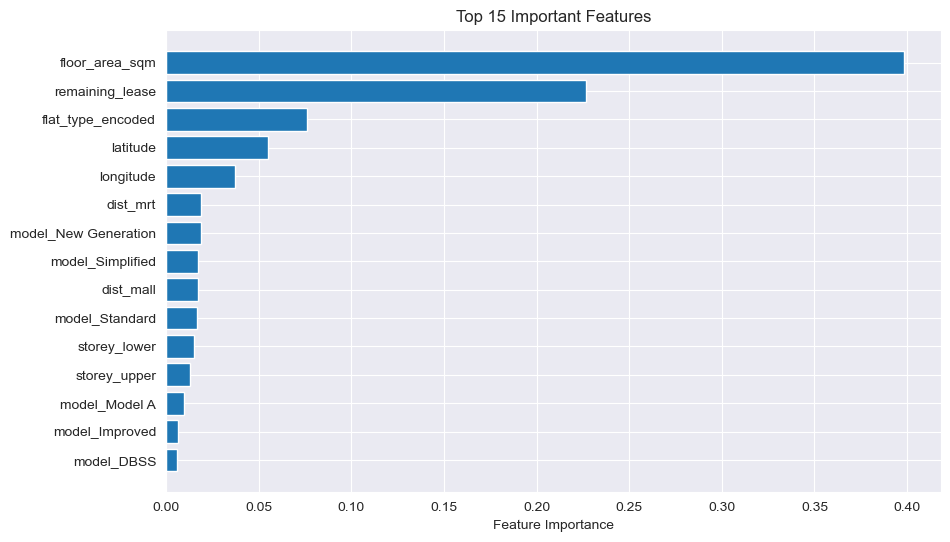

In [68]:
importances = best_rf.feature_importances_
feature_names = X_train.columns

feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'], feat_df['Importance'])
plt.xlabel("Feature Importance")
plt.title("Top 15 Important Features")
plt.gca().invert_yaxis()
plt.show()

As seen from the above visualisation, we see that `floor_area_sqm`, `remaining_lease`, `flat_type_encoded` are the most important features in predicting the `resale_price`, validating the visualisations that we had earlier in this report.

We also noticed something interesting, `dist_mrt` and `dist_mall`, even though the correlation from the earlier visualisation were not significant to the target feature (`log_resale_price`), it still played a partial role in predicting the `resale_price` for our Random Forest Regressor.

Another interesting thing we noticed were the `latitude` and `longtitude` columns seem to be more important than the encoded towns that we have in our dataframe indicating that they may be redundant features included in the our dataset, given that we have collected the `latitude` and `longtitude` data. 

Given these observations, we can say our spatial data collected was useful in the model training.

### Clearing Redundant Features

We can test their redundancy by retraining the models without these features, to see if the performance of Random Forest Regressor will improve. We will now use a copy of the df_encoded dataframe with its towns columns dropped to do the retraining of the model.

In [69]:
df_encoded_copy = df_encoded.copy()
df_encoded_copy.drop(columns=[col for col in df_encoded.columns if col.startswith('town_')], inplace=True)
df_encoded_copy.columns

Index(['floor_area_sqm', 'remaining_lease', 'month_recorded',
       'log_resale_price', 'latitude', 'longitude', 'dist_mrt', 'dist_mall',
       'storey_lower', 'storey_upper', 'flat_type_encoded', 'model_2-room',
       'model_3Gen', 'model_Adjoined flat', 'model_Apartment', 'model_DBSS',
       'model_Improved', 'model_Improved-Maisonette', 'model_Maisonette',
       'model_Model A', 'model_Model A-Maisonette', 'model_Model A2',
       'model_Multi Generation', 'model_New Generation',
       'model_Premium Apartment', 'model_Premium Apartment Loft',
       'model_Premium Maisonette', 'model_Simplified', 'model_Standard',
       'model_Terrace', 'model_Type S1', 'model_Type S2'],
      dtype='object')

In [74]:
# preparation for train-validation-test split
target = "log_resale_price"
features = [col for col in df_encoded_copy.columns if col != target]

# train-validation-test split [training (70%), validation (15%), and testing (15%)]
X_train, X_test, y_train, y_test = train_test_split(df_encoded_copy[features], df_encoded_copy[target], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# init linear regression model, random forest and xgboost model
models2 = {
    "Random Forest": RandomForestRegressor(max_depth = None, min_samples_split = 10, n_estimators = 100, random_state=42, n_jobs=-1)
}

# training models and evaluating their performance using validation set (15%)
results = []
for name, model in models2.items():
    model.fit(X_train, y_train)

    # val data 
    y_pred_log = model.predict(X_val)
    y_pred = np.exp(y_pred_log)
    y_true = np.exp(y_val)  

    # train data
    y_pred_log_train = model.predict(X_train)
    y_pred_train = np.exp(y_pred_log_train)
    y_true_train = np.exp(y_train)  

    # calculate rmse r2 and mae for each model
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)


    rmse_train = root_mean_squared_error(y_true_train, y_pred_train)
    r2_train = r2_score(y_true_train, y_pred_train)
    mae_train = mean_absolute_error(y_true_train, y_pred_train)


    results.append({"Model": name, "RMSE_Train": rmse_train, "R² Score_Train": r2_train, "MAE_Train": mae_train ,"RMSE_Test": rmse, "R² Score_Test": r2, "MAE_Test": mae})

# convert results to a dataframe to print it
results_df = pd.DataFrame(results)


In [75]:
results_df

,Model,RMSE_Train,R² Score_Train,MAE_Train,RMSE_Test,R² Score_Test,MAE_Test
0,Random Forest,"22,798.5896649",0.9829409,"14,799.6482092","34,984.7191994",0.9597195,"22,369.4300263"


In [72]:
df_encoded_copy.shape

(660656, 32)

Based on the results above, we see that there is no significant changes despite us dropping the one-hot encoded town columns, indicating that they actually does not contribute much to the model's decision making. We also understand now that `latitude` and `longtitude` are able to cover the spacial aspect of our dataset. 

Despite the performance not showing signs of major improvement, the act of removing redundant columns is still beneficial to us as it makes model training and inference much faster as we managed to cut our dataset from 55 columns to 32 columns.

We can then move on to official testing to evaluate the true robustness of our model on unseen data. 

## Official Testing

Finally, we can conclude this study by testing our model using the best parameter on the test dataset, reserved from earlier. 

In [76]:
# prediction on test set
y_pred_test_log = model.predict(X_test)
y_pred_test = np.exp(y_pred_test_log)
y_true_test = np.exp(y_test)

y_pred_train_log = model.predict(X_train)
y_pred_train = np.exp(y_pred_train_log)
y_true_train = np.exp(y_train)

print("Train RMSE:", root_mean_squared_error(y_true_train, y_pred_train))
print("Train MAE:", mean_absolute_error(y_true_train, y_pred_train))
print("Train R²:", r2_score(y_true_train, y_pred_train))
print()
print("Test RMSE:", root_mean_squared_error(y_true_test, y_pred_test))
print("Test MAE:", mean_absolute_error(y_true_test, y_pred_test))
print("Test R²:", r2_score(y_true_test, y_pred_test))


Train RMSE: 22798.5896648513
Train MAE: 14799.648209183664
Train R²: 0.9829408720966024

Test RMSE: 35170.49327162237
Test MAE: 22320.343863428556
Test R²: 0.9593422703387563


From the above results, we see that the performance achieve has little to no difference between the previous evaluations, indicating that the model generalizes well despite the slight overfitting. Hence, it should be able to perform well in real-life scenario.